In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedShuffleSplit

from pathlib import Path
import cloudpickle as pkl

In [2]:
target = 'personal_loan'
model_date = '20241204'
version = 1
algo = 'xgb'

model_name = f'{target}_{algo}_{model_date}_v{version}'
with open(f'{target}/{model_name}/model.pkl', 'rb') as model_file:
    model = pkl.load(model_file)

In [3]:
train_data = pd.read_csv(f'{target}/train_data_{target}.csv', low_memory=False)
test_data = pd.read_csv(f'{target}/test_data_{target}.csv', low_memory=False)

x_train = train_data.drop('target', axis=1)
y_train = train_data['target']
x_test = test_data.drop('target', axis=1)
y_test = test_data['target']

x_train.shape

(2154079, 14)

In [4]:
iso_calibrated_model = CalibratedClassifierCV(model, method='isotonic', cv='prefit')
iso_calibrated_model.fit(x_train, y_train)
platt_calibrated_model = CalibratedClassifierCV(model, method='sigmoid', cv='prefit')
platt_calibrated_model.fit(x_train, y_train)

CalibratedClassifierCV(cv='prefit',
                       estimator=XGBClassifier(base_score=None, booster=None,
                                               callbacks=None,
                                               colsample_bylevel=None,
                                               colsample_bynode=None,
                                               colsample_bytree=0.8,
                                               device=None,
                                               early_stopping_rounds=None,
                                               enable_categorical=False,
                                               eval_metric='logloss',
                                               feature_types=None, gamma=2,
                                               grow_policy=None,
                                               importance_type=None,
                                               interaction_constraints=None,
                                               lambda=0.1, learning_rate=0.01,
                                               max_bin=None,
                                               max_cat_threshold=None,
                                               max_cat_to_onehot=None,
                                               max_delta_step=None, max_depth=3,
                                               max_leaves=None,
                                               min_child_weight=None,
                                               missing=nan,
                                               monotone_constraints=None,
                                               multi_strategy=None,
                                               n_estimators=500, n_jobs=6,
                                               num_parallel_tree=None, ...))

## Basic Evaluation

1. Train & Test Gini
2. Decile
3. Feature Importances Plot

In [5]:
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
train_auc_scores = []
for train_index, test_index in sss.split(x_train, y_train):
    x_val, y_val = x_train.iloc[train_index], y_train.iloc[train_index]
    y_pred_proba = iso_calibrated_model.predict_proba(x_val)
    train_auc_scores.append(roc_auc_score(y_val, y_pred_proba[:, 1]))
    
train_auc = np.mean(train_auc_scores)
print(f"""
Train Gini:
    Fold 1: {2 * train_auc_scores[0] - 1:.2f}
    Fold 2: {2 * train_auc_scores[1] - 1:.2f}
    Fold 3: {2 * train_auc_scores[2] - 1:.2f}
    Fold 4: {2 * train_auc_scores[3] - 1:.2f}
    Fold 5: {2 * train_auc_scores[4] - 1:.2f}
    
Average Gini = {2 * train_auc - 1:.2f}
""")


Train Gini:
    Fold 1: 0.59
    Fold 2: 0.59
    Fold 3: 0.59
    Fold 4: 0.59
    Fold 5: 0.59
    
Average Gini = 0.59



In [6]:
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
test_auc_scores = []
for train_index, test_index in sss.split(x_test, y_test):
    x_val, y_val = x_test.iloc[train_index], y_test.iloc[train_index]
    y_pred_proba = iso_calibrated_model.predict_proba(x_val)
    test_auc_scores.append(roc_auc_score(y_val, y_pred_proba[:, 1]))

test_auc = np.mean(test_auc_scores)
print(f"""
Test Gini:
    Fold 1: {2 * test_auc_scores[0] - 1:.2f}
    Fold 2: {2 * test_auc_scores[1] - 1:.2f}
    Fold 3: {2 * test_auc_scores[2] - 1:.2f}
    Fold 4: {2 * test_auc_scores[3] - 1:.2f}
    Fold 5: {2 * test_auc_scores[4] - 1:.2f}

Average Gini = {2 * test_auc - 1:.2f}
""")


Test Gini:
    Fold 1: 0.59
    Fold 2: 0.59
    Fold 3: 0.59
    Fold 4: 0.59
    Fold 5: 0.59

Average Gini = 0.59



In [7]:
y_pred_proba = iso_calibrated_model.predict_proba(x_test)[:, 1]
deciles = pd.qcut(pd.Series(y_pred_proba).rank(method='first'), q=10, labels=False, duplicates='raise') + 1
deciles_df = pd.DataFrame({
    'Probability': y_pred_proba,
    'Actual': y_test,
    'Decile': deciles,
    'Bin Size': 1
}).sort_values(['Decile', 'Probability'],ascending=False)

agg_deciles_df = deciles_df.groupby('Decile').agg({
    'Probability': ['mean', 'nunique'],
    'Actual':'sum',
    'Bin Size': 'sum'
}).reset_index().sort_values(['Decile'], ascending=False)
agg_deciles_df['Actual'] = agg_deciles_df.pop('Actual')

agg_deciles_df['response_rate'] = agg_deciles_df['Actual'] / y_test.shape[0]
agg_deciles_df['decile_recall'] = agg_deciles_df['Actual'] / y_test.sum()
agg_deciles_df['capture_rate'] = agg_deciles_df['Actual'].cumsum() * 100 / y_test.sum()
agg_deciles_df['Bin Size'] = agg_deciles_df.pop('Bin Size')
agg_deciles_df

Decile Probability         Actual response_rate decile_recall capture_rate  \
                mean nunique                                                   
9     10    0.034589      55   1878      0.003487      0.401883    40.188316   
8      9    0.016617      10    851      0.001580      0.182110    58.399315   
7      8    0.012727      26    714      0.001326      0.152793    73.678579   
6      7    0.007733      14    421      0.000782      0.090092    82.687781   
5      6    0.006189      18    313      0.000581      0.066981    89.385834   
4      5    0.003935      37    230      0.000427      0.049219    94.307725   
3      4    0.002478      24    130      0.000241      0.027819    97.089664   
2      3    0.001844      20    107      0.000199      0.022897    99.379414   
1      2    0.000477      21     29      0.000054      0.006206   100.000000   
0      1    0.000004       5      0      0.000000      0.000000   100.000000   

  Bin Size  
            
9    53852  
8    53852  
7    53852  
6    53852  
5    53852  
4    53852  
3    53852  
2    53852  
1    53852  
0    53852

In [8]:
y_pred_proba_train = iso_calibrated_model.predict_proba(x_train)[:, 1]
deciles_train = pd.qcut(pd.Series(y_pred_proba_train).rank(method='first'), q=10, labels=False) + 1
deciles_df_train = pd.DataFrame({
    'Probability': y_pred_proba_train,
    'Actual': y_train,
    'Decile': deciles_train,
    'Bin Size': 1
}).sort_values(['Decile', 'Probability'],ascending=False)

agg_deciles_df_train = deciles_df_train.groupby('Decile').agg({
    'Probability': ['mean', 'nunique'],
    'Actual': 'sum',
    'Bin Size': 'sum'
}).reset_index().sort_values(['Decile'], ascending=False)
agg_deciles_df_train['Actual'] = agg_deciles_df_train.pop('Actual')

agg_deciles_df_train['response_rate'] = agg_deciles_df_train['Actual'] / y_train.shape[0]
agg_deciles_df_train['decile_recall'] = agg_deciles_df_train['Actual'] / y_train.sum()
agg_deciles_df_train['capture_rate'] = agg_deciles_df_train['Actual'].cumsum() * 100 / y_train.sum()
agg_deciles_df_train['Bin Size'] = agg_deciles_df_train.pop('Bin Size')
agg_deciles_df_train

Decile Probability         Actual response_rate decile_recall capture_rate  \
                mean nunique                                                   
9     10    0.034689      55   7482  3.473410e-03      0.400278    40.027819   
8      9    0.016620      19   3564  1.654535e-03      0.190670    59.094800   
7      8    0.012767      38   2747  1.275255e-03      0.146961    73.790927   
6      7    0.007766      33   1669  7.748091e-04      0.089290    82.719880   
5      6    0.006206      28   1340  6.220756e-04      0.071688    89.888722   
4      5    0.003944      63    855  3.969214e-04      0.045741    94.462872   
3      4    0.002488      38    536  2.488302e-04      0.028675    97.330409   
2      3    0.001841      26    395  1.833730e-04      0.021132    99.443612   
1      2    0.000473      33    103  4.781626e-05      0.005510    99.994650   
0      1    0.000004       6      1  4.642355e-07      0.000053   100.000000   

  Bin Size  
            
9   215408  
8   215408  
7   215408  
6   215408  
5   215407  
4   215408  
3   215408  
2   215408  
1   215408  
0   215408

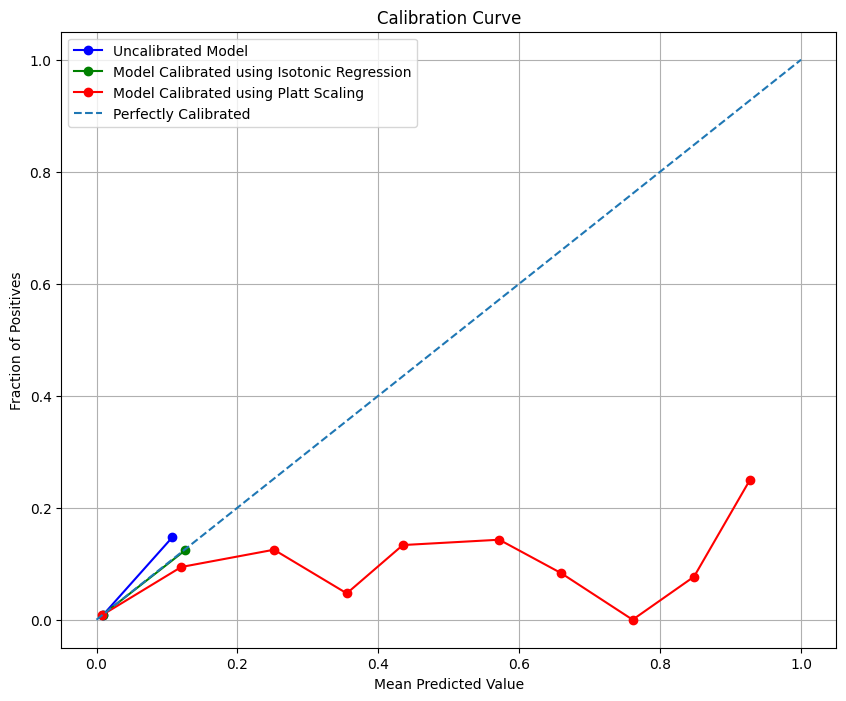

In [9]:
n_bins = 10
fraction_of_positives_uncal, mean_predicted_value_uncal = calibration_curve(
    y_test, model.predict_proba(x_test)[:, 1], n_bins=n_bins)

fraction_of_positives_iso_cal, mean_predicted_value_iso_cal = calibration_curve(
    y_test, iso_calibrated_model.predict_proba(x_test)[:, 1], n_bins=n_bins)

fraction_of_positives_platt_cal, mean_predicted_value_platt_cal = calibration_curve(
    y_test, platt_calibrated_model.predict_proba(x_test)[:, 1], n_bins=n_bins)

plt.figure(figsize=(10, 8))

plt.plot(mean_predicted_value_uncal, fraction_of_positives_uncal, 
         marker='o', label='Uncalibrated Model', linestyle='-', color='blue')

plt.plot(mean_predicted_value_iso_cal, fraction_of_positives_iso_cal, 
         marker='o', label='Model Calibrated using Isotonic Regression', linestyle='-', color='green')

plt.plot(mean_predicted_value_platt_cal, fraction_of_positives_platt_cal, 
         marker='o', label='Model Calibrated using Platt Scaling', linestyle='-', color='red')

plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated')

plt.title('Calibration Curve')
plt.xlabel('Mean Predicted Value')
plt.ylabel('Fraction of Positives')
plt.legend(loc='best')
plt.grid(True)
plt.show()

In [10]:
raise Exception("Choose which calibration to use after looking at the above graph")

Exception: Choose which calibration to use after looking at the above graph

In [12]:
with open(f'{target}/{model_name}/calibrated_model.pkl', 'wb') as calibrated_model_file:
    pkl.dump(iso_calibrated_model, calibrated_model_file)

In [ ]:
print(f"""
Test Average event rate:            {np.mean(y_test) * 100:.4f} %
Test Average predicted probability: {np.mean(y_pred_proba) * 100:.4f} %
""")

In [11]:
print(f"""
Train Average event rate:            {np.mean(y_train) * 100:.4f} %
Train Average predicted probability: {np.mean(y_pred_proba_train) * 100:.4f} %
""")


Train Average event rate:            0.8677 %
Train Average predicted probability: 0.8680 %



In [ ]:
np.mean(y_pred_proba_train), np.mean(y_train)